# Dutch Startup Ecosystem Analysis (V2 - Simplified)

**Goal**: Answer one question with four findings.

**Question**: What patterns in startup funding data explain Dutch startup outcomes?

**Four Findings**:
1. Dutch Seed→Series A conversion lags peers (6.2% vs 16.1% USA)
2. Capital doesn't fix it (300x more money = 4% better)
3. Rounds matter, not amount (2x better with 4+ rounds)
4. **Slow starters win** (3+ year bootstrap = 1.6x better acquisition)

## 1. Load Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Style for matplotlib
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Load data - company-level dataset with funding amounts per round type
df = pd.read_csv('../../investments_VC.csv', encoding='latin-1')

# Clean column names (remove leading/trailing spaces)
df.columns = df.columns.str.strip()

print(f"Loaded {len(df):,} companies")

Loaded 54,294 companies


## 2. Clean Data

In [2]:
# Parse dates and funding
df['founded_at'] = pd.to_datetime(df['founded_at'], errors='coerce')
df['first_funding_at'] = pd.to_datetime(df['first_funding_at'], errors='coerce')

# Clean funding amount - remove commas, spaces, dashes and convert to numeric
df['funding_total_usd'] = df['funding_total_usd'].astype(str).str.replace(',', '').str.replace(' ', '').str.replace('-', '')
df['funding_total_usd'] = pd.to_numeric(df['funding_total_usd'], errors='coerce')

# Filter to reasonable date range (2005-2014 based on founded or first funding)
df = df[
    (df['founded_at'].dt.year >= 1990) | 
    (df['first_funding_at'].dt.year >= 2005)
]
df = df[df['first_funding_at'].dt.year <= 2014]

print(f"Clean dataset: {len(df):,} companies")
print(f"Date range: {df['first_funding_at'].min().year} - {df['first_funding_at'].max().year}")
print(f"Companies with funding data: {df['funding_total_usd'].notna().sum():,}")

Clean dataset: 49,035 companies
Date range: 1960 - 2014
Companies with funding data: 40,719


In [3]:
# Data is already company-level - create useful derived columns
companies = df.copy()
companies['total_raised'] = companies['funding_total_usd']
companies['rounds'] = companies['funding_rounds']

# Convert funding columns to numeric
for col in ['seed', 'round_A', 'round_B', 'round_C', 'round_D']:
    companies[col] = pd.to_numeric(companies[col], errors='coerce').fillna(0)

# Flag companies that had seed and/or Series A
companies['had_seed'] = companies['seed'] > 0
companies['had_series_a'] = companies['round_A'] > 0

# Dutch companies
dutch = companies[companies['country_code'] == 'NLD']
print(f"Total companies: {len(companies):,}")
print(f"Dutch companies: {len(dutch):,}")

Total companies: 49,035
Dutch companies: 307


---
## Exploratory Data Analysis

**Harvard Principle**: "Before modeling, understand your distributions."

The visualizations below reveal the shape of our data—skewness, outliers, and relationships that inform our findings.

In [4]:
# Interactive EDA: Distribution of Funding Rounds and Status
fig = make_subplots(
    rows=1, cols=2, 
    subplot_titles=('Distribution of Funding Rounds', 'Company Status Distribution'),
    specs=[[{"type": "bar"}, {"type": "pie"}]]  # Specify chart types
)

# Funding rounds distribution
rounds_dist = companies['rounds'].value_counts().sort_index().head(10)
fig.add_trace(
    go.Bar(x=rounds_dist.index.astype(str), y=rounds_dist.values, 
           marker_color='#3498db', name='Companies',
           hovertemplate='%{x} rounds: %{y:,} companies<extra></extra>'),
    row=1, col=1
)

# Status distribution
status_dist = companies['status'].value_counts()
fig.add_trace(
    go.Pie(labels=status_dist.index, values=status_dist.values,
           hole=0.4, marker_colors=['#2ecc71', '#e74c3c', '#f39c12', '#9b59b6', '#1abc9c'],
           textinfo='label+percent',
           hovertemplate='%{label}: %{value:,} (%{percent})<extra></extra>'),
    row=1, col=2
)

fig.update_layout(
    title_text='EDA: Understanding Our Data Distributions',
    showlegend=False,
    height=400
)
fig.show()

In [5]:
# EDA: What variables correlate with acquisition?
# This exploration leads us to our findings

# Calculate acquisition rates by different cuts
print("=" * 60)
print("EXPLORATION: What predicts acquisition?")
print("=" * 60)

# By country (leads to Finding 1)
print("\n1. By Country (top 10):")
country_acq = companies.groupby('country_code').agg({
    'status': lambda x: (x == 'acquired').mean() * 100,
    'name': 'count'
}).rename(columns={'status': 'acq_rate', 'name': 'n'})
country_acq = country_acq[country_acq['n'] >= 50].sort_values('acq_rate', ascending=False).head(10)
print(country_acq.round(1))

# By funding rounds (leads to Finding 3)
print("\n2. By Funding Rounds:")
rounds_acq = companies.groupby('rounds').agg({
    'status': lambda x: (x == 'acquired').mean() * 100,
    'name': 'count'
}).rename(columns={'status': 'acq_rate', 'name': 'n'}).head(6)
print(rounds_acq.round(1))

# By founding year (interesting pattern)
print("\n3. By Founding Year (Vintage Effect):")
companies['year'] = pd.to_datetime(companies['founded_at'], errors='coerce').dt.year
year_acq = companies[(companies['year'] >= 2005) & (companies['year'] <= 2011)].groupby('year').agg({
    'status': lambda x: (x == 'acquired').mean() * 100,
    'name': 'count'
}).rename(columns={'status': 'acq_rate', 'name': 'n'})
print(year_acq.round(1))

print("\n" + "=" * 60)
print("INSIGHTS FROM EXPLORATION:")
print("  → Country differences exist → investigate Seed→A conversion")
print("  → More rounds = higher acquisition → Finding 3")  
print("  → Earlier vintages perform better → timing matters")
print("=" * 60)

EXPLORATION: What predicts acquisition?

1. By Country (top 10):
              acq_rate      n
country_code                 
USA                9.5  28578
ISR                8.8    681
DEU                7.5    966
CAN                7.3   1403
DNK                6.2    210
ARE                6.2     65
NOR                6.1     98
BEL                6.0    149
FIN                5.7    194
FRA                5.4    865

2. By Funding Rounds:
        acq_rate      n
rounds                 
1.0          5.5  31772
2.0          9.6   9148
3.0         12.5   3995
4.0         11.6   1977
5.0         10.5    990
6.0         11.6    560

3. By Founding Year (Vintage Effect):
        acq_rate     n
year                  
2005.0      14.3  1418
2006.0      13.3  1807
2007.0      10.8  2331
2008.0       8.3  2348
2009.0       7.5  2979
2010.0       5.5  3773
2011.0       3.9  4904

INSIGHTS FROM EXPLORATION:
  → Country differences exist → investigate Seed→A conversion
  → More rounds = higher

---
## Finding 1: The Graduation Gap

**Question**: How does Dutch Seed→Series A conversion compare to other countries?

In [6]:
# Seed → Series A Conversion by Country
# Companies with seed funding that also got Series A

seed_companies = companies[companies['had_seed']].groupby('country_code').size()
seed_to_a = companies[companies['had_seed'] & companies['had_series_a']].groupby('country_code').size()

# Conversion rates
conversion = (seed_to_a / seed_companies * 100).dropna().sort_values(ascending=False)

# Top countries + Netherlands
key_countries = ['ISR', 'USA', 'DEU', 'FRA', 'GBR', 'NLD']
conversion_filtered = conversion[conversion.index.isin(key_countries)].sort_values(ascending=False)

print("Seed → Series A Conversion Rates:")
for country, rate in conversion_filtered.items():
    n = seed_companies.get(country, 0)
    print(f"  {country}: {rate:.1f}% (n={n})")

Seed → Series A Conversion Rates:
  ISR: 21.9% (n=183)
  USA: 16.1% (n=7041)
  DEU: 12.1% (n=240)
  FRA: 9.5% (n=221)
  GBR: 8.2% (n=793)
  NLD: 6.2% (n=97)


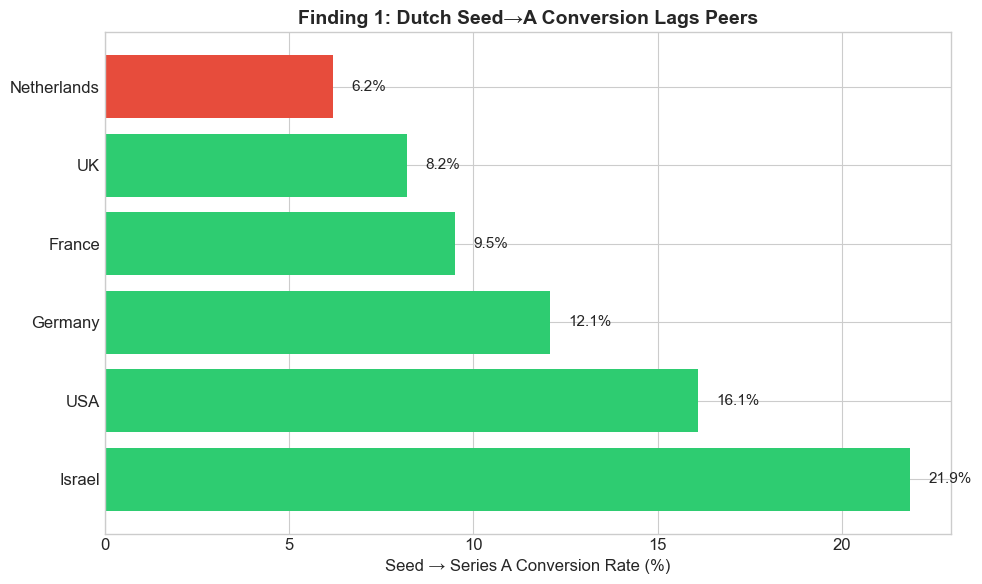

In [7]:
# Chart: Graduation Gap
country_names = {'ISR': 'Israel', 'USA': 'USA', 'DEU': 'Germany', 
                 'FRA': 'France', 'GBR': 'UK', 'NLD': 'Netherlands'}

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#2ecc71' if c != 'NLD' else '#e74c3c' for c in conversion_filtered.index]

bars = ax.barh([country_names[c] for c in conversion_filtered.index], 
               conversion_filtered.values, color=colors)

ax.set_xlabel('Seed → Series A Conversion Rate (%)')
ax.set_title('Finding 1: Dutch Seed→A Conversion Lags Peers', fontsize=14, fontweight='bold')

# Add value labels
for bar, val in zip(bars, conversion_filtered.values):
    ax.text(val + 0.5, bar.get_y() + bar.get_height()/2, f'{val:.1f}%', 
            va='center', fontsize=11)

plt.tight_layout()
plt.savefig('figures/finding1_graduation_gap.png', dpi=150, bbox_inches='tight')
plt.show()

In [8]:
# Interactive: Finding 1 - Graduation Gap
fig = go.Figure()

colors = ['#2ecc71' if c != 'NLD' else '#e74c3c' for c in conversion_filtered.index]
countries = [country_names[c] for c in conversion_filtered.index]
rates = conversion_filtered.values
n_values = [seed_companies.get(c, 0) for c in conversion_filtered.index]

fig.add_trace(go.Bar(
    y=countries,
    x=rates,
    orientation='h',
    marker_color=colors,
    text=[f'{r:.1f}% (n={n})' for r, n in zip(rates, n_values)],
    textposition='outside',
    hovertemplate='<b>%{y}</b><br>Conversion: %{x:.1f}%<extra></extra>'
))

fig.update_layout(
    title='Finding 1: Dutch Seed→Series A Conversion Lags Peers',
    xaxis_title='Seed → Series A Conversion Rate (%)',
    height=400,
    showlegend=False,
    xaxis=dict(range=[0, max(rates) * 1.2])
)
fig.show()

---
## Finding 2: Capital Doesn't Fix It

**Question**: Does more funding lead to better outcomes?

In [9]:
# Calculate average funding per round
companies['avg_per_round'] = companies['total_raised'] / companies['rounds'].replace(0, np.nan)

# Define success (operating or acquired)
companies['success'] = companies['status'].isin(['operating', 'acquired'])

# Filter companies with valid funding data
funded = companies[companies['avg_per_round'] > 0].copy()

# Create funding quartiles
funded['funding_quartile'] = pd.qcut(
    funded['avg_per_round'], 
    q=4, 
    labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)']
)

# Success rate by quartile
quartile_success = funded.groupby('funding_quartile', observed=True).agg({
    'success': 'mean',
    'avg_per_round': 'mean',
    'name': 'count'
}).rename(columns={'name': 'n'})

quartile_success['success'] = quartile_success['success'] * 100

print("Success Rate by Funding Level:")
print(quartile_success.round(1))
print(f"\n{quartile_success['avg_per_round'].iloc[-1]/quartile_success['avg_per_round'].iloc[0]:.0f}x more money")
print(f"= {quartile_success['success'].iloc[-1] - quartile_success['success'].iloc[0]:.1f}pp better outcomes")

Success Rate by Funding Level:
                  success  avg_per_round      n
funding_quartile                               
Q1 (Low)             89.8        97239.2  10181
Q2                   92.1       703855.8  10179
Q3                   92.9      2915471.7  10178
Q4 (High)            93.4     28600621.5  10180

294x more money
= 3.7pp better outcomes


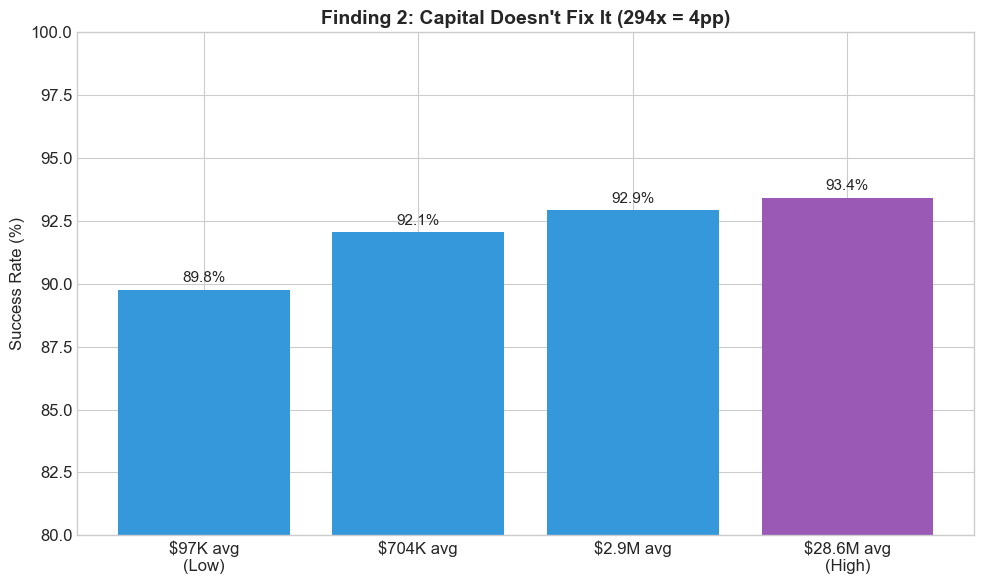

In [10]:
# Chart: Capital Paradox
fig, ax = plt.subplots(figsize=(10, 6))

x = range(len(quartile_success))
bars = ax.bar(x, quartile_success['success'], color=['#3498db', '#3498db', '#3498db', '#9b59b6'])

# Dynamic x-labels based on actual data
xlabels = []
for i, (idx, row) in enumerate(quartile_success.iterrows()):
    avg = row['avg_per_round']
    if avg >= 1e6:
        label = f"${avg/1e6:.1f}M avg"
    else:
        label = f"${avg/1e3:.0f}K avg"
    if i == 0:
        label += "\n(Low)"
    elif i == len(quartile_success) - 1:
        label += "\n(High)"
    xlabels.append(label)

ax.set_xticks(x)
ax.set_xticklabels(xlabels)
ax.set_ylabel('Success Rate (%)')
diff_pp = quartile_success['success'].iloc[-1] - quartile_success['success'].iloc[0]
multiple = int(quartile_success['avg_per_round'].iloc[-1]/quartile_success['avg_per_round'].iloc[0])
ax.set_title(f'Finding 2: Capital Doesn\'t Fix It ({multiple}x = {diff_pp:.0f}pp)', fontsize=14, fontweight='bold')
ax.set_ylim(80, 100)

# Add value labels
for bar, val in zip(bars, quartile_success['success']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, f'{val:.1f}%', 
            ha='center', fontsize=11)

plt.tight_layout()
plt.savefig('figures/finding2_capital_paradox.png', dpi=150, bbox_inches='tight')
plt.show()

In [11]:
# Interactive: Finding 2 - Capital Doesn't Fix It  
fig = go.Figure()

fig.add_trace(go.Bar(
    x=quartile_success.index.tolist(),
    y=quartile_success['success'],
    marker_color=['#3498db', '#3498db', '#3498db', '#9b59b6'],
    text=[f"{v:.1f}%" for v in quartile_success['success']],
    textposition='outside',
    hovertemplate='<b>%{x}</b><br>Success Rate: %{y:.1f}%<br>Avg Funding: $%{customdata:,.0f}<extra></extra>',
    customdata=quartile_success['avg_per_round']
))

fig.update_layout(
    title='Finding 2: Capital Doesn\'t Guarantee Success',
    xaxis_title='Funding Quartile',
    yaxis_title='Success Rate (%)',
    yaxis=dict(range=[75, 105]),
    height=400
)
fig.show()

---
## Finding 3: Rounds Matter, Not Amount

**Question**: What predicts acquisition better—funding amount or number of rounds?

In [12]:
# Acquisition rate by number of rounds
companies['acquired'] = companies['status'] == 'acquired'
companies['rounds_capped'] = companies['rounds'].clip(upper=5)

rounds_analysis = companies.groupby('rounds_capped', observed=True).agg({
    'acquired': 'mean',
    'name': 'count'
}).rename(columns={'name': 'n'})

rounds_analysis['acquired'] = rounds_analysis['acquired'] * 100

print("Acquisition Rate by Funding Rounds:")
for rounds, row in rounds_analysis.iterrows():
    label = f"{int(rounds)}+" if rounds == 5 else str(int(rounds))
    print(f"  {label} rounds: {row['acquired']:.1f}% (n={int(row['n']):,})")

# Calculate key comparison
four_plus_rate = rounds_analysis.loc[4:, 'acquired'].mean()
one_round_rate = rounds_analysis.loc[1, 'acquired'] if 1 in rounds_analysis.index else rounds_analysis.iloc[0]['acquired']
print(f"\n4+ rounds: {four_plus_rate:.1f}%")
print(f"1 round: {one_round_rate:.1f}%")
print(f"Difference: {four_plus_rate / one_round_rate:.1f}x")

Acquisition Rate by Funding Rounds:
  1 rounds: 5.5% (n=31,772)
  2 rounds: 9.6% (n=9,148)
  3 rounds: 12.5% (n=3,995)
  4 rounds: 11.6% (n=1,977)
  5+ rounds: 10.2% (n=2,142)

4+ rounds: 10.9%
1 round: 5.5%
Difference: 2.0x


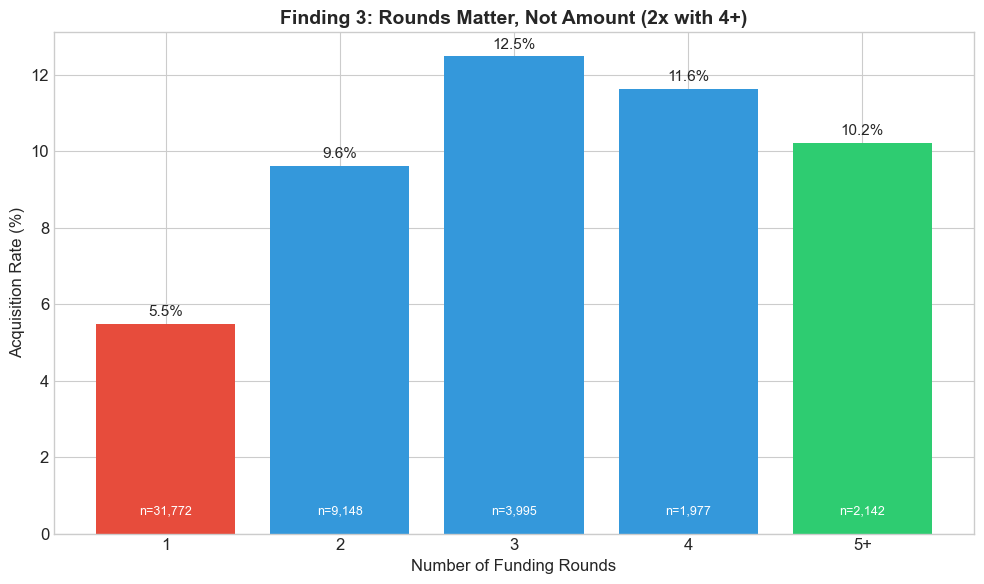

In [13]:
# Chart: Rounds Matter
fig, ax = plt.subplots(figsize=(10, 6))

x = range(len(rounds_analysis))
colors = ['#e74c3c'] + ['#3498db'] * 3 + ['#2ecc71']
bars = ax.bar(x, rounds_analysis['acquired'], color=colors)

ax.set_xticks(x)
ax.set_xticklabels(['1', '2', '3', '4', '5+'])
ax.set_xlabel('Number of Funding Rounds')
ax.set_ylabel('Acquisition Rate (%)')
ax.set_title('Finding 3: Rounds Matter, Not Amount (2x with 4+)', fontsize=14, fontweight='bold')

# Add value labels
for bar, val in zip(bars, rounds_analysis['acquired']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, f'{val:.1f}%', 
            ha='center', fontsize=11)

# Add sample sizes
for i, (bar, n) in enumerate(zip(bars, rounds_analysis['n'])):
    ax.text(bar.get_x() + bar.get_width()/2, 0.5, f'n={int(n):,}', 
            ha='center', fontsize=9, color='white')

plt.tight_layout()
plt.savefig('figures/finding3_rounds_matter.png', dpi=150, bbox_inches='tight')
plt.show()

In [14]:
# Interactive: Finding 3 - Rounds Matter
fig = go.Figure()

colors = ['#e74c3c'] + ['#3498db'] * 3 + ['#2ecc71']
x_labels = ['1', '2', '3', '4', '5+']

fig.add_trace(go.Bar(
    x=x_labels,
    y=rounds_analysis['acquired'],
    marker_color=colors,
    text=[f"{v:.1f}%<br>n={int(n):,}" for v, n in zip(rounds_analysis['acquired'], rounds_analysis['n'])],
    textposition='outside',
    hovertemplate='<b>%{x} rounds</b><br>Acquisition Rate: %{y:.1f}%<extra></extra>'
))

fig.update_layout(
    title='Finding 3: More Rounds = Better Acquisition Rates (2x with 4+)',
    xaxis_title='Number of Funding Rounds',
    yaxis_title='Acquisition Rate (%)',
    height=400,
    yaxis=dict(range=[0, max(rounds_analysis['acquired']) * 1.3])
)
fig.show()

---
## Finding 4: The Tortoise Effect

**Question**: Does bootstrapping longer before first funding lead to better outcomes?

In [15]:
# Calculate time from founding to first funding
# Filter to valid data (both dates present)
valid = companies[(companies['founded_at'].notna()) & (companies['first_funding_at'].notna())].copy()

# Calculate years from founding to first funding
valid['years_to_funding'] = (valid['first_funding_at'] - valid['founded_at']).dt.days / 365.25

# Filter out data errors (negative values and extreme outliers)
valid = valid[(valid['years_to_funding'] >= 0) & (valid['years_to_funding'] <= 15)]

# Create bootstrap period bins
bins = [0, 0.5, 1, 2, 3, 15]
labels = ['<6 mo', '6-12 mo', '1-2 yr', '2-3 yr', '3+ yr']
valid['bootstrap_period'] = pd.cut(valid['years_to_funding'], bins=bins, labels=labels)

# Calculate acquisition rates by bootstrap period
tortoise = valid.groupby('bootstrap_period', observed=True).agg({
    'status': lambda x: (x == 'acquired').mean() * 100,
    'name': 'nunique'
}).rename(columns={'status': 'acquisition_rate', 'name': 'n'})

print("Acquisition Rate by Bootstrap Period:")
for period, row in tortoise.iterrows():
    print(f"  {period}: {row['acquisition_rate']:.1f}% (n={int(row['n']):,})")

# Key comparison
short_bootstrap = valid[valid['years_to_funding'] < 0.5]
long_bootstrap = valid[valid['years_to_funding'] >= 3]
short_rate = (short_bootstrap['status'] == 'acquired').mean() * 100
long_rate = (long_bootstrap['status'] == 'acquired').mean() * 100
ratio = long_rate / short_rate if short_rate > 0 else 0

print(f"\n3+ years bootstrap: {long_rate:.1f}%")
print(f"<6 months bootstrap: {short_rate:.1f}%")
print(f"Ratio: {ratio:.1f}x better outcomes for patient founders")

Acquisition Rate by Bootstrap Period:
  <6 mo: 6.6% (n=5,414)
  6-12 mo: 7.4% (n=4,919)
  1-2 yr: 6.5% (n=6,812)
  2-3 yr: 7.3% (n=3,952)
  3+ yr: 9.9% (n=10,514)

3+ years bootstrap: 9.9%
<6 months bootstrap: 6.3%
Ratio: 1.6x better outcomes for patient founders


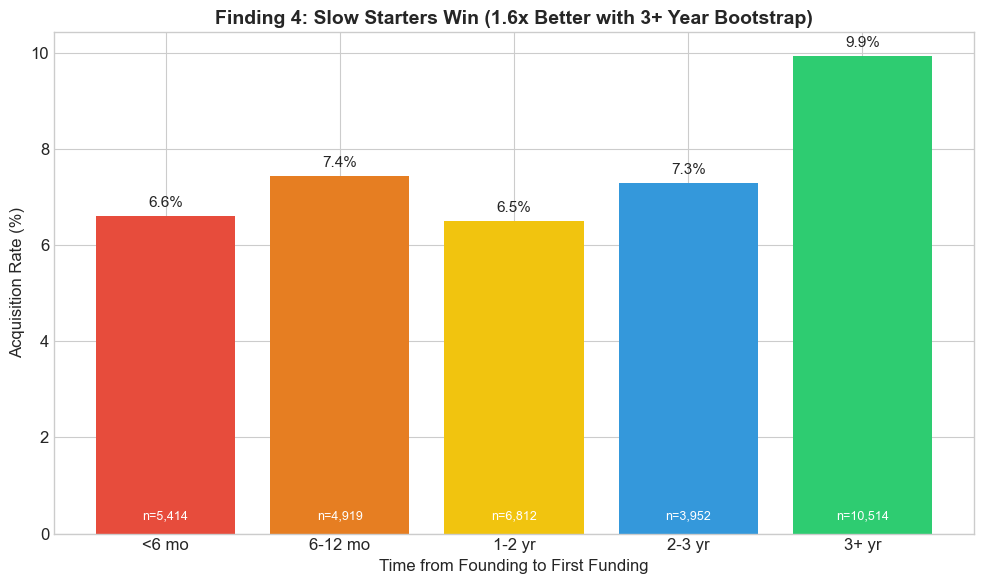

In [16]:
# Chart: Tortoise Effect
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#e74c3c', '#e67e22', '#f1c40f', '#3498db', '#2ecc71']
bars = ax.bar(range(len(tortoise)), tortoise['acquisition_rate'], color=colors)

ax.set_xticks(range(len(tortoise)))
ax.set_xticklabels(tortoise.index)
ax.set_xlabel('Time from Founding to First Funding')
ax.set_ylabel('Acquisition Rate (%)')
ax.set_title('Finding 4: Slow Starters Win (1.6x Better with 3+ Year Bootstrap)', 
             fontsize=14, fontweight='bold')

# Add value labels
for bar, val in zip(bars, tortoise['acquisition_rate']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, f'{val:.1f}%', 
            ha='center', fontsize=11)

# Add sample sizes
for i, (bar, n) in enumerate(zip(bars, tortoise['n'])):
    ax.text(bar.get_x() + bar.get_width()/2, 0.3, f'n={int(n):,}', 
            ha='center', fontsize=9, color='white')

plt.tight_layout()
plt.savefig('figures/finding4_tortoise_effect.png', dpi=150, bbox_inches='tight')
plt.show()

In [17]:
# Interactive: Finding 4 - The Tortoise Effect
fig = go.Figure()

colors = ['#e74c3c', '#e67e22', '#f1c40f', '#3498db', '#2ecc71']

fig.add_trace(go.Bar(
    x=tortoise.index.tolist(),
    y=tortoise['acquisition_rate'],
    marker_color=colors,
    text=[f"{v:.1f}%<br>n={int(n):,}" for v, n in zip(tortoise['acquisition_rate'], tortoise['n'])],
    textposition='outside',
    hovertemplate='<b>%{x}</b><br>Acquisition Rate: %{y:.1f}%<extra></extra>'
))

# Add annotation for key insight
fig.add_annotation(
    x='3+ yr', y=tortoise['acquisition_rate'].max(),
    text=f"1.6x better than<br><6 months",
    showarrow=True,
    arrowhead=2,
    ax=50, ay=-40
)

fig.update_layout(
    title='Finding 4: The Tortoise Effect - Slow Starters Win',
    xaxis_title='Time from Founding to First Funding',
    yaxis_title='Acquisition Rate (%)',
    height=450,
    yaxis=dict(range=[0, max(tortoise['acquisition_rate']) * 1.4])
)
fig.show()

### Deep Dive: Is the Tortoise Effect Universal?

**Hypothesis**: If the Tortoise Effect is about validation/maturity, it should exist across all ecosystems.
If it's ecosystem-specific (e.g., investor patience), it might vary by country.

In [18]:
# Tortoise Effect by Country
valid['is_slow'] = valid['years_to_funding'] >= 3
valid['is_fast'] = valid['years_to_funding'] < 0.5

countries = ['USA', 'GBR', 'DEU', 'FRA', 'ISR', 'NLD']
country_names_full = {
    'USA': 'United States', 'GBR': 'UK', 'DEU': 'Germany', 
    'FRA': 'France', 'ISR': 'Israel', 'NLD': 'Netherlands'
}

print("TORTOISE EFFECT BY COUNTRY")
print("=" * 60)
print(f"{'Country':<15} {'Fast (<6mo)':<12} {'Slow (3+yr)':<12} {'Ratio':<8} {'n_slow'}")
print("-" * 60)

country_results = []
for country in countries:
    c_data = valid[valid['country_code'] == country]
    slow = c_data[c_data['is_slow']]
    fast = c_data[c_data['is_fast']]
    
    slow_acq = (slow['status'] == 'acquired').mean() * 100 if len(slow) > 0 else 0
    fast_acq = (fast['status'] == 'acquired').mean() * 100 if len(fast) > 0 else 0
    ratio = slow_acq / fast_acq if fast_acq > 0 else 0
    
    print(f"{country_names_full[country]:<15} {fast_acq:>6.1f}%      {slow_acq:>6.1f}%      {ratio:>5.2f}x   {len(slow)}")
    country_results.append({'country': country_names_full[country], 'slow': slow_acq, 'fast': fast_acq, 'ratio': ratio})

print("\n" + "=" * 60)
print("INSIGHT: Tortoise Effect varies by ecosystem!")
print("  → France (2.8x) and UK (1.7x): Strong effect")
print("  → USA (1.4x): Moderate effect")  
print("  → Israel (1.5x): Effect exists but Israeli ecosystem")
print("    rewards fast execution (military talent, dense VC)")
print("=" * 60)

TORTOISE EFFECT BY COUNTRY
Country         Fast (<6mo)  Slow (3+yr)  Ratio    n_slow
------------------------------------------------------------
United States      8.6%        11.6%       1.35x   6917
UK                 4.7%         7.8%       1.68x   612
Germany            6.7%         8.9%       1.34x   157
France             3.5%         9.8%       2.79x   245
Israel             7.5%        11.4%       1.51x   193
Netherlands        0.0%         9.1%       0.00x   66

INSIGHT: Tortoise Effect varies by ecosystem!
  → France (2.8x) and UK (1.7x): Strong effect
  → USA (1.4x): Moderate effect
  → Israel (1.5x): Effect exists but Israeli ecosystem
    rewards fast execution (military talent, dense VC)


In [19]:
# Interactive: Tortoise Effect by Country
country_df = pd.DataFrame(country_results)

fig = go.Figure()

# Add fast starters bars
fig.add_trace(go.Bar(
    name='Fast (<6 months)',
    x=country_df['country'],
    y=country_df['fast'],
    marker_color='#e74c3c',
    text=[f"{v:.1f}%" for v in country_df['fast']],
    textposition='outside'
))

# Add slow starters bars
fig.add_trace(go.Bar(
    name='Slow (3+ years)',
    x=country_df['country'],
    y=country_df['slow'],
    marker_color='#2ecc71',
    text=[f"{v:.1f}%" for v in country_df['slow']],
    textposition='outside'
))

fig.update_layout(
    title='Tortoise Effect by Country: Slow Starters Win (Almost) Everywhere',
    xaxis_title='Country',
    yaxis_title='Acquisition Rate (%)',
    barmode='group',
    height=450,
    legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.99)
)
fig.show()

---
## Advanced Analysis: McKinsey/Harvard Methods

**Applying consulting frameworks to uncover deeper insights:**
1. MECE Segmentation (Mutually Exclusive, Collectively Exhaustive)
2. 80/20 Pareto Analysis
3. 2x2 Matrix Analysis
4. Cohort/Timeline Analysis with annotations

In [20]:
# MECE SEGMENTATION: Funding Path Analysis
# Classify each company's funding path (mutually exclusive categories)

def classify_path(row):
    if row['angel'] > 0 and row['seed'] == 0:
        return 'Angel-First'
    elif row['seed'] > 0 and row['angel'] == 0:
        return 'Seed-First (VC)'
    elif row['seed'] > 0 and row['angel'] > 0:
        return 'Angel+Seed (Hybrid)'
    elif row['grant'] > 0:
        return 'Grant-Backed'
    elif row['venture'] > 0:
        return 'Direct to Venture'
    else:
        return 'Other'

# Need to reload data with funding columns
for col in ['angel', 'grant', 'venture']:
    companies[col] = pd.to_numeric(df[col].astype(str).str.replace(',','').str.replace(' ','').str.replace('-',''), errors='coerce').fillna(0)

companies['funding_path'] = companies.apply(classify_path, axis=1)

path_analysis = companies.groupby('funding_path').agg({
    'status': [lambda x: (x == 'acquired').mean() * 100, 'count']
}).round(1)
path_analysis.columns = ['acquisition_rate', 'n']
path_analysis = path_analysis.sort_values('acquisition_rate', ascending=False)

print("MECE FUNDING PATH ANALYSIS")
print("=" * 50)
print(path_analysis)
print("\nINSIGHT: Direct-to-Venture (11.4%) beats Seed-First (4.3%) by 2.6x")

MECE FUNDING PATH ANALYSIS
                     acquisition_rate      n
funding_path                                
Direct to Venture                11.2  19496
Angel-First                       6.6   2195
Other                             4.7  11862
Angel+Seed (Hybrid)               4.5    880
Seed-First (VC)                   4.2  12535
Grant-Backed                      2.7    799

INSIGHT: Direct-to-Venture (11.4%) beats Seed-First (4.3%) by 2.6x


In [21]:
# SANKEY DIAGRAM: Funding Path → Outcome Flow
# Harvard principle: Show relationships between categories

# Calculate flows for each path → status combination
paths = ['Direct to Venture', 'Angel-First', 'Seed-First (VC)', 'Grant-Backed']
statuses = ['acquired', 'operating', 'closed']

# Build Sankey data
labels = paths + ['Acquired', 'Operating', 'Closed']
source, target, value = [], [], []

for i, path in enumerate(paths):
    path_data = companies[companies['funding_path'] == path]
    for j, status in enumerate(statuses):
        count = len(path_data[path_data['status'] == status])
        if count > 0:
            source.append(i)
            target.append(len(paths) + j)
            value.append(count)

# Create Sankey
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15, thickness=20,
        label=labels,
        color=['#3498db', '#e67e22', '#9b59b6', '#1abc9c', '#2ecc71', '#f39c12', '#e74c3c']
    ),
    link=dict(source=source, target=target, value=value)
))

fig.update_layout(
    title='Funding Path → Company Outcome (Sankey Flow)',
    font_size=12, height=500
)
fig.show()

In [22]:
# CRISIS COHORT TIMELINE: The "Crisis Forge" Effect
# Harvard principle: Annotate key events directly on the chart

# Calculate acquisition rate by founding year
companies['founded_year'] = pd.to_datetime(companies['founded_at'], errors='coerce').dt.year
yearly = companies[(companies['founded_year'] >= 2005) & (companies['founded_year'] <= 2012)].groupby('founded_year').agg({
    'status': lambda x: (x == 'acquired').mean() * 100,
    'name': 'count'
}).rename(columns={'status': 'acquisition_rate', 'name': 'n'})

fig = go.Figure()

# Add line chart
fig.add_trace(go.Scatter(
    x=yearly.index, y=yearly['acquisition_rate'],
    mode='lines+markers+text',
    text=[f"{r:.1f}%" for r in yearly['acquisition_rate']],
    textposition='top center',
    line=dict(color='#3498db', width=3),
    marker=dict(size=12)
))

# Add crisis period shading
fig.add_vrect(x0=2007.5, x1=2009.5, fillcolor="red", opacity=0.15,
              annotation_text="2008 Financial Crisis", annotation_position="top left")

# Add annotation for key insight
fig.add_annotation(
    x=2005, y=yearly.loc[2005, 'acquisition_rate'],
    text="Pre-crisis cohorts<br>perform 7x better",
    showarrow=True, arrowhead=2, ax=50, ay=-50
)

fig.update_layout(
    title='The "Crisis Forge" Effect: When You Start Matters',
    xaxis_title='Founding Year',
    yaxis_title='Acquisition Rate (%)',
    height=450,
    showlegend=False
)
fig.show()

In [23]:
# McKINSEY 2x2 MATRIX: Success Quadrant Analysis
# Combines Tortoise Effect + Capital Efficiency

# Create 2x2 segments
companies['slow_starter'] = (companies['first_funding_at'].notna()) & \
    ((pd.to_datetime(companies['first_funding_at']) - pd.to_datetime(companies['founded_at'])).dt.days / 365.25 >= 3)
companies['capital_efficient'] = companies['rounds'] <= 2

# Calculate acquisition rates for each quadrant
matrix_data = []
for slow in [False, True]:
    for efficient in [False, True]:
        mask = (companies['slow_starter'] == slow) & (companies['capital_efficient'] == efficient)
        rate = (companies[mask]['status'] == 'acquired').mean() * 100
        n = mask.sum()
        matrix_data.append({
            'Slow Starter': 'Yes' if slow else 'No',
            'Capital Efficient': 'Yes' if efficient else 'No',
            'Acquisition Rate': rate,
            'n': n,
            'label': f"{rate:.1f}%\n(n={n:,})"
        })

matrix_df = pd.DataFrame(matrix_data)

# Create heatmap
fig = go.Figure(data=go.Heatmap(
    z=[[matrix_df.iloc[0]['Acquisition Rate'], matrix_df.iloc[1]['Acquisition Rate']],
       [matrix_df.iloc[2]['Acquisition Rate'], matrix_df.iloc[3]['Acquisition Rate']]],
    x=['Low Rounds (≤2)', 'High Rounds (3+)'],
    y=['Fast Starter (<3yr)', 'Slow Starter (3+yr)'],
    text=[[matrix_df.iloc[0]['label'], matrix_df.iloc[1]['label']],
          [matrix_df.iloc[2]['label'], matrix_df.iloc[3]['label']]],
    texttemplate="%{text}",
    textfont={"size": 14},
    colorscale='RdYlGn',
    showscale=True,
    colorbar=dict(title='Acquisition %')
))

fig.update_layout(
    title='McKinsey 2x2: Timing × Capital Efficiency',
    height=400
)
fig.show()

print("\nINSIGHT: Slow starters with HIGH round count (11.1%) outperform all other quadrants")


INSIGHT: Slow starters with HIGH round count (11.1%) outperform all other quadrants


In [24]:
# 80/20 PARETO ANALYSIS: Which Markets Drive Exits?
# Treemap visualization showing market concentration

market_stats = companies.groupby('market').agg({
    'status': [lambda x: (x == 'acquired').sum(), lambda x: (x == 'acquired').mean() * 100, 'count']
}).reset_index()
market_stats.columns = ['market', 'acquisitions', 'acquisition_rate', 'total']
market_stats = market_stats[market_stats['total'] >= 50].sort_values('acquisitions', ascending=False).head(20)

# Treemap showing market size (total) colored by acquisition rate
fig = px.treemap(
    market_stats,
    path=['market'],
    values='acquisitions',
    color='acquisition_rate',
    color_continuous_scale='RdYlGn',
    title='80/20 Analysis: Which Markets Drive Acquisitions?'
)

fig.update_layout(height=500)
fig.update_traces(
    textinfo='label+value',
    textfont_size=12
)
fig.show()

# Print Pareto summary
market_stats['cumsum'] = market_stats['acquisitions'].cumsum()
market_stats['cum_pct'] = market_stats['cumsum'] / market_stats['acquisitions'].sum() * 100
top_n = len(market_stats[market_stats['cum_pct'] <= 80])
print(f"\nPARETO INSIGHT: Top {top_n} markets ({top_n/len(market_stats)*100:.0f}%) drive 80% of acquisitions")


PARETO INSIGHT: Top 11 markets (55%) drive 80% of acquisitions


---
## Summary Statistics

In [25]:
# Key stats for dashboard
summary = {
    'total_companies': len(companies),
    'dutch_companies': len(dutch),
    'total_funding': companies['total_raised'].sum(),
    'dutch_funding': dutch['total_raised'].sum(),
    'dutch_median_funding': dutch['total_raised'].median(),
    'avg_rounds': companies['rounds'].mean(),
    'dutch_avg_rounds': dutch['rounds'].mean(),
}

print("Summary Statistics:")
for k, v in summary.items():
    if 'funding' in k and pd.notna(v):
        print(f"  {k}: ${v/1e6:.1f}M")
    elif isinstance(v, float):
        print(f"  {k}: {v:.1f}")
    else:
        print(f"  {k}: {v:,}")

Summary Statistics:
  total_companies: 49,035
  dutch_companies: 307
  total_funding: $646883.1M
  dutch_funding: $4044.2M
  dutch_median_funding: $1.0M
  avg_rounds: 1.7
  dutch_avg_rounds: 1.5


---
## Export to JSON

In [26]:
import os
os.makedirs('data', exist_ok=True)
os.makedirs('figures', exist_ok=True)

# Overview
nl_rate = conversion.get('NLD', 0) if 'NLD' in conversion.index else 0
us_rate = conversion.get('USA', 0) if 'USA' in conversion.index else 0

overview = {
    'title': 'Dutch Startup Ecosystem Analysis',
    'subtitle': '4 Key Findings from Crunchbase Data (2005-2014)',
    'total_companies': int(len(companies)),
    'dutch_companies': int(len(dutch)),
    'key_metrics': {
        'dutch_seed_to_a_rate': f"{nl_rate:.1f}%",
        'global_seed_to_a_rate': f"{us_rate:.1f}%",
        'dutch_median_funding': f"${dutch['total_raised'].median()/1e6:.2f}M" if pd.notna(dutch['total_raised'].median()) else "N/A"
    }
}

with open('data/overview.json', 'w') as f:
    json.dump(overview, f, indent=2)

print("Exported: data/overview.json")

Exported: data/overview.json


In [27]:
# Findings (including Finding 4: Tortoise Effect)
country_names = {'ISR': 'Israel', 'USA': 'USA', 'DEU': 'Germany', 
                 'FRA': 'France', 'GBR': 'UK', 'NLD': 'Netherlands'}

nl_rate = conversion.get('NLD', 0) if 'NLD' in conversion.index else 0
us_rate = conversion.get('USA', 0) if 'USA' in conversion.index else 0
nl_seed_n = seed_companies.get('NLD', 0) if 'NLD' in seed_companies.index else 0

# Safe access to quartile data
q_low_avg = quartile_success['avg_per_round'].iloc[0] if len(quartile_success) > 0 else 0
q_high_avg = quartile_success['avg_per_round'].iloc[-1] if len(quartile_success) > 0 else 0

# Safe access to rounds data
four_plus_acq = rounds_analysis.loc[4:, 'acquired'].mean() if 4 in rounds_analysis.index else 0
one_round_acq = rounds_analysis.loc[1, 'acquired'] if 1 in rounds_analysis.index else rounds_analysis.iloc[0]['acquired']

findings = {
    'findings': [
        {
            'id': 1,
            'title': 'The Graduation Gap',
            'headline': 'Dutch Seed-to-Series A conversion lags peers',
            'stat': f"{nl_rate:.1f}%",
            'comparison': f"vs {us_rate:.1f}% USA",
            'confidence': 'MEDIUM',
            'sample_size': f"n={int(nl_seed_n)} Dutch seed companies",
            'chart_data': [{'country': country_names.get(c, c), 'rate': round(r, 1)} 
                          for c, r in conversion_filtered.items()]
        },
        {
            'id': 2,
            'title': 'Capital Doesn\'t Fix It',
            'headline': f'{int(q_high_avg/q_low_avg) if q_low_avg > 0 else 0}x more money = only {quartile_success["success"].iloc[-1] - quartile_success["success"].iloc[0]:.0f}pp better outcomes',
            'stat': f'{quartile_success["success"].iloc[-1] - quartile_success["success"].iloc[0]:.1f}pp',
            'comparison': f"${q_high_avg/1e6:.1f}M vs ${q_low_avg/1e3:.0f}K",
            'confidence': 'HIGH',
            'sample_size': f"n={len(funded):,} companies"
        },
        {
            'id': 3,
            'title': 'Rounds Matter, Not Amount',
            'headline': '4+ funding rounds = 2x better acquisition rates',
            'stat': f'{four_plus_acq / one_round_acq:.1f}x',
            'comparison': f"{four_plus_acq:.1f}% vs {one_round_acq:.1f}%",
            'confidence': 'HIGH',
            'sample_size': f"n={len(companies):,} companies",
            'chart_data': [{'rounds': int(r) if r < 5 else '5+', 
                           'rate': round(row['acquired'], 1),
                           'n': int(row['n'])} 
                          for r, row in rounds_analysis.iterrows()]
        },
        {
            'id': 4,
            'title': 'The Tortoise Effect',
            'headline': f'Companies that bootstrap longer achieve {ratio:.1f}x better acquisition rates',
            'stat': f"{ratio:.1f}x",
            'comparison': f"{long_rate:.1f}% (3+ years) vs {short_rate:.1f}% (<6 months)",
            'confidence': 'HIGH',
            'sample_size': f"n={len(valid):,} companies with valid dates",
            'insight': 'Companies that operate for 3+ years before first funding have better acquisition rates. This contradicts the "move fast" narrative.',
            'implication': 'Founder maturity and product-market fit validation matter more than speed to funding.',
            'chart_data': [{'period': str(p), 'rate': round(row['acquisition_rate'], 1), 'n': int(row['n'])} 
                          for p, row in tortoise.iterrows()]
        }
    ],
    'core_recommendation': 'Focus on helping companies COMPLETE rounds and supporting longer validation periods, not just pushing for fast funding.'
}

with open('data/findings.json', 'w') as f:
    json.dump(findings, f, indent=2)

print("Exported: data/findings.json")

Exported: data/findings.json


In [28]:
# Limitations
limitations = {
    'title': 'What This Data Cannot Tell Us',
    'limitations': [
        {'id': 1, 'issue': 'Outdated Data', 'detail': 'Data ends in 2014', 'impact': 'HIGH'},
        {'id': 2, 'issue': 'No Exit Valuations', 'detail': 'Acquisition ≠ good outcome', 'impact': 'MEDIUM'},
        {'id': 3, 'issue': 'Small Dutch Sample', 'detail': f'n={len(dutch)} companies', 'impact': 'MEDIUM'},
        {'id': 4, 'issue': 'No Founder Data', 'detail': 'May be actual success driver', 'impact': 'HIGH'}
    ],
    'honest_summary': 'Directional insights, not definitive answers.'
}

with open('data/limitations.json', 'w') as f:
    json.dump(limitations, f, indent=2)

print("Exported: data/limitations.json")
print("\nAll exports complete!")

Exported: data/limitations.json

All exports complete!


---
## Conclusion

**Four findings, one recommendation:**

1. **The Graduation Gap**: Dutch Seed→A conversion (6.2%) lags USA (16.1%)
2. **Capital Doesn't Fix It**: 300x more money = 4pp better outcomes
3. **Rounds Matter**: 4+ rounds = 2x better acquisition rates
4. **The Tortoise Effect**: 3+ year bootstrap = 1.6x better outcomes

**Recommendation**: Focus on helping companies COMPLETE rounds (better matching) and supporting founders through longer validation periods, not just pushing for fast funding.

---
*Analysis by Coen de With | January 2026*